In [102]:
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import prune

import numpy as np
import matplotlib.pyplot as plt
import copy

plt.rcParams['font.family'] = 'Bookman Old Style'


class dataset:
    def __init__(self, x, y, num_training_points=5000, num_validation_points=5000, 
                 num_test_points=10000, num_memory_levels_nn=3, training_start_idx=0):
        """
        Initialize dataset with flexible data split ranges.
        
        Args:
            x: Clean PA input signal
            y: PA output signal (distorted)
            num_training_points: Number of samples for training (default 5000)
            num_validation_points: Number of samples for validation (default 5000)
            num_test_points: Number of samples for test (default 10000)
            num_memory_levels_nn: Number of memory taps for NN features (default 3)
            training_start_idx: Starting index for training data (default 0)
        """
        self.num_training_points = num_training_points
        self.num_validation_points = num_validation_points
        self.num_test_points = num_test_points
        self.num_memory_levels_nn = num_memory_levels_nn  # For NN feature extraction
        self.x = x
        self.y = y
        
        # Calculate data split indices based on number of points
        self.training_start_idx = training_start_idx
        self.validation_start_idx = training_start_idx + num_training_points
        self.test_start_idx = self.validation_start_idx + num_validation_points

        self.model_training_input, self.model_training_output, self.training_phase, self.model_valid_input, self.model_valid_output, self.valid_phase = self.prepare_data()
        self.model_training_xfc = self.get_model_training_xfc()
        self.model_training_expected_output = self.get_model_training_expected_output()
        self.model_valid_xfc = self.get_valid_xfc()
        self.model_valid_expected_output = self.get_model_valid_expected_output()

        self.test_input, self.test_output = self.get_leftover_test_data()

        
    def phase_vector(self, x):    
        """Takes a vector x and returns a vector of phases of each element"""
        Ax = np.abs(x)
        return np.conj(x)/Ax

    def model_expected_output(self, y, phase, num_memory_levels):
        """
        Denormalize phase and prepare output for NN training.
        Input y: The target output (clean PA input x in our case)
        Returns: [I, Q] pairs after phase denormalization
        """
        y_denorm = y*phase
        y_denorm_trim = y_denorm[num_memory_levels:]
        return np.array([np.real(y_denorm_trim), np.imag(y_denorm_trim)]).T

    def build_xfc(self, x, num_memory_levels):
        """
        Replicates the MATLAB build_xfc() function.
        Fixed: All features now use x[n-m] for proper time alignment.
        """
        num_points = len(x)
        phase = self.phase_vector(x)
        I = np.real(x)
        Q = np.imag(x)

        phase_norm_data = np.zeros((num_points, num_memory_levels), dtype=complex)
        for n in range(num_memory_levels, num_points):
            for m in range(num_memory_levels):
                phase_norm_data[n, m] = x[n - m] * phase[n]

        # Ax magnitude feature
        Ax = np.sqrt(I**2 + Q**2)

        # Build A feature matrix (Ax memory taps) - uses x[n-m]
        A_feats = np.zeros((num_points, num_memory_levels))
        for n in range(num_memory_levels, num_points):
            for m in range(num_memory_levels):
                A_feats[n, m] = Ax[n - m]

        # Trim first num_memory_levels samples (as in MATLAB)
        phase_norm_data = phase_norm_data[num_memory_levels:, :]
        A_feats = A_feats[num_memory_levels:, :]
        A3_feats = A_feats ** 3

        # Combine real and imaginary phase-normalized parts with A-features
        xfc = np.hstack([
            np.real(phase_norm_data),
            np.imag(phase_norm_data),
            A_feats,
            A3_feats
        ]).astype(np.float32)

        return xfc

    def build_x_matrix(self, x, num_mem_levels, num_nl_orders):
        """Build Matrix X for find Volterra Model"""
        num_points = len(x)
        X = np.zeros((num_points, num_mem_levels * num_nl_orders), dtype=np.complex128)
        
        for n in range(num_mem_levels - 1, num_points):
            col = 0
            for i in range(num_mem_levels):
                xi = x[n - i]
                for j in range(num_nl_orders):
                    X[n, col] = (abs(xi) ** ((j) * 2)) * xi
                    col += 1

        return X

    def build_y(self, u, A, num_mem_levels, num_nl_orders):
        """Builds y, the output of the volterra Model. Trims Output"""
        num_points = len(u)
        y = np.zeros((num_points, 1), dtype=np.complex128)
        for n in range(num_mem_levels - 1, num_points):
            col = 0 
            for i in range(num_mem_levels):
                ui = u[n-i]
                for j in range(num_nl_orders):
                    y[n]= y[n] + A[col]*(abs(ui)**(j*2)*ui)
                    col += 1
        y = y[num_mem_levels:]  # Use parameter, not self.num_memory_levels
        return y
            

    def volterra(self, input, output, num_nl_orders, num_memory_levels=3):
        """Build component matrix A"""
        X = self.build_x_matrix(input, num_memory_levels, num_nl_orders)
        
        X_trim = X[num_memory_levels:, :]
        y_trim = output[num_memory_levels:]
        return np.linalg.pinv(X_trim.conj().T @ X_trim) @ (X_trim.conj().T @ y_trim);

    def training_data(self):
        """
        Assign training data for inverse PA model.
        In the imported data: x = clean PA input, y = PA output (distorted, no DPD)
        For inverse model (y -> x): input is PA output (y), output is clean input (x)
        
        Uses training_start_idx to select data region.
        """
        training_end_idx = self.training_start_idx + self.num_training_points
        idx_training = range(self.training_start_idx, training_end_idx - 1)

        model_training_input = self.y[idx_training]   # PA output (distorted)
        model_training_output = self.x[idx_training]  # Clean PA input (desired)
        return model_training_input, model_training_output
    

    def get_validation_data(self):
        """
        Assign validation data for inverse PA model.
        In the imported data: x = clean PA input, y = PA output (distorted, no DPD)
        
        Uses validation_start_idx and num_validation_points to select data region.
        """
        validation_end_idx = self.validation_start_idx + self.num_validation_points
        idx_validation = range(self.validation_start_idx, validation_end_idx - 1)
        
        model_valid_input = self.y[idx_validation]   # PA output (distorted)
        model_valid_output = self.x[idx_validation]  # Clean PA input (desired)
        return model_valid_input, model_valid_output
    
    def get_leftover_test_data(self):
        """
        Get data left over that wasn't used for validation or training.
        
        Uses test_start_idx and num_test_points to select data region.
        """
        test_end_idx = self.test_start_idx + self.num_test_points
        
        x_test = self.x[self.test_start_idx:test_end_idx]
        y_test = self.y[self.test_start_idx:test_end_idx]
        return x_test, y_test

    def prepare_data(self):
        """Prepare training and validation data sets"""
        # Training Data
        model_training_input, model_training_output = self.training_data()
        training_phase = self.phase_vector(model_training_input)

        # Validation Data
        model_valid_input, model_valid_output = self.get_validation_data()
        valid_phase = self.phase_vector(model_valid_input)
        return (model_training_input, model_training_output, training_phase,
                model_valid_input, model_valid_output, valid_phase)

    def get_model_training_xfc(self):
        """Build xfc from model training input using NN memory levels"""
        return self.build_xfc(self.model_training_input, self.num_memory_levels_nn)
    
    def get_model_training_expected_output(self):
        """Find what the model should output for training data"""
        return self.model_expected_output(self.model_training_output, self.training_phase, self.num_memory_levels_nn)
    
    def get_valid_xfc(self):
        """Build xfc from model validation input using NN memory levels"""
        return self.build_xfc(self.model_valid_input, self.num_memory_levels_nn)
    
    def get_test_xfc(self):
        return self.build_xfc(self.test_input, self.num_memory_levels_nn)
    
    def get_model_valid_expected_output(self):
        """Find what the model should output for validation data"""
        return self.model_expected_output(self.model_valid_output, self.valid_phase, self.num_memory_levels_nn)

    
    def plot_volterra_vs_actual(self, A, num_memory_levels, num_nl_orders, num_samples=800):
        """
        Plot Volterra model output vs actual PA output to validate model accuracy
        
        Args:
            A: Volterra coefficients
            num_memory_levels: Number of memory levels
            num_nl_orders: Number of nonlinear orders
            num_samples: Number of random samples to plot (default 800)
        """
        volterra_output = self.build_y(self.model_training_output, A, num_memory_levels, num_nl_orders)
        actual_output = self.model_training_input[num_memory_levels:]
        input_trimmed = self.model_training_output[num_memory_levels:]

        # Select random data points
        total_points = len(input_trimmed)
        random_indices = np.random.choice(total_points, size=min(num_samples, total_points), replace=False)

        # Create scatter plot showing PA characteristic: input |x| vs output |y|
        plt.figure(figsize=(10, 8))
        plt.scatter(np.abs(input_trimmed[random_indices]), np.abs(actual_output[random_indices]), 
                    alpha=0.7, label='Actual PA Output', s=10, color='blue')
        plt.scatter(np.abs(input_trimmed[random_indices]), np.abs(volterra_output.squeeze()[random_indices]), 
                    alpha=0.7, label='Volterra Model Output', s=10, color='red')
        plt.plot([0, 1], [0, 1], 'k--', label='Linear (y=x)', linewidth=2)
        plt.xlabel('Input Magnitude |x|')
        plt.ylabel('Output Magnitude |y|')
        plt.title('PA Characteristics: Volterra Model vs Actual PA Output\n(Validation of Volterra Model Accuracy)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def plot_pa_characteristic(self, num_samples=800):
        """
        Plot the PA input-output characteristic showing compression
        
        Args:
            num_samples: Number of random samples to plot (default 800)
        """
        # Use the actual PA input and output from training data
        # Use NN memory levels as a reasonable default for trimming
        pa_input = self.model_training_output[self.num_memory_levels_nn:]
        pa_output = self.model_training_input[self.num_memory_levels_nn:]

        # Select random data points for cleaner visualization
        total_points = len(pa_input)
        random_indices = np.random.choice(total_points, size=min(num_samples, total_points), replace=False)

        # Create scatter plot showing PA characteristic: input |x| vs output |y|
        plt.figure(figsize=(10, 8))
        plt.scatter(np.abs(pa_input[random_indices]), np.abs(pa_output[random_indices]), 
                    alpha=0.7, label='PA Output', s=10, color='blue')
        plt.plot([0, 1], [0, 1], 'k--', label='Linear (y=x)', linewidth=2)
        plt.xlabel('PA Input Magnitude |x|')
        plt.ylabel('PA Output Magnitude |y|')
        plt.title('Power Amplifier Characteristic\n(Shows AM/AM compression)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def calculate_volterra_nmse(self, A, num_memory_levels, num_nl_orders):
        """
        Calculate NMSE in dB for Volterra model prediction
        
        Args:
            A: Volterra coefficients
            num_memory_levels: Number of memory levels
            num_nl_orders: Number of nonlinear orders
            
        Returns:
            NMSE in dB
        """
        # Get Volterra model output (build_y trims num_memory_levels from output)
        volterra_output = self.build_y(self.test_input, A, num_memory_levels, num_nl_orders).squeeze()
        actual_output = self.test_output[num_memory_levels:]
        
        # Ensure both arrays are the same length
        min_len = min(len(volterra_output), len(actual_output))
        volterra_output = volterra_output[:min_len]
        actual_output = actual_output[:min_len]
        
        # Calculate NMSE
        error_power = np.mean(np.abs(volterra_output - actual_output)**2)
        signal_power = np.mean(np.abs(actual_output)**2)
        nmse = error_power / signal_power
        nmse_db = 10 * np.log10(nmse)
        
        return nmse_db
    
    def plot_volterra_nmse_vs_memory_depth(self, num_nl_orders=5, max_memory_levels=10):
        """
        Plot NMSE of Volterra model vs memory depth
        
        Args:
            num_nl_orders: Number of nonlinear orders (default 5)
            max_memory_levels: Maximum memory depth to test (default 10)
        """
        memory_depths = range(1, max_memory_levels + 1)
        nmse_values = []
        
        print("Computing NMSE for different memory depths...")
        for mem_depth in memory_depths:
            # Compute Volterra coefficients for this memory depth
            A = self.volterra(input=self.model_training_output, output=self.model_training_input, num_nl_orders=num_nl_orders, num_memory_levels=mem_depth)
            
            # Calculate NMSE
            nmse_db = self.calculate_volterra_nmse(A, mem_depth, num_nl_orders)
            nmse_values.append(nmse_db)
            
            print(f"Memory depth {mem_depth}: NMSE = {nmse_db:.2f} dB")
        
        # Plot results
        plt.figure(figsize=(10, 6))
        plt.plot(memory_depths, nmse_values, marker='o', linewidth=2, markersize=8, color='tab:blue')
        plt.xlabel('Memory Depth (Number of Memory Levels)', fontsize=12)
        plt.ylabel('NMSE (dB)', fontsize=12)
        plt.title(f'Volterra Model Performance vs Memory Depth\n(Nonlinear Orders = {num_nl_orders})', 
                  fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.xticks(memory_depths)
        
        plt.tight_layout()
        plt.show()
        
        return memory_depths, nmse_values

    def evaluate_inverse_volterra_through_pa(self, x, A_forward, A_inverse, num_memory_levels_forward, num_nl_orders_forward, num_memory_levels_inverse, num_nl_orders_inverse):
        """
        Evaluate inverse Volterra predistortion through PA model.
        
        Args:
            x: Input signal
            A_forward: Forward PA model coefficients
            A_inverse: Inverse model coefficients for predistortion
            num_memory_levels_forward: Memory levels for forward PA model
            num_nl_orders_forward: Nonlinear orders for forward PA model
            num_memory_levels_inverse: Memory levels for inverse model
            num_nl_orders_inverse: Nonlinear orders for inverse model
        """
        # Apply inverse Volterra (predistortion)
        volterra_predistorted_full = self.build_y(x, A_inverse, num_memory_levels_inverse, num_nl_orders_inverse).squeeze()
        
        # Pass through forward PA model
        pa_output = self.build_y(volterra_predistorted_full, A_forward, num_memory_levels_forward, num_nl_orders_forward).squeeze()
        
        # Align all arrays properly:
        # - x needs double trimming (sum of both memory levels)
        # - volterra_predistorted_full was trimmed once, needs one more trim
        # - pa_output is already double-trimmed implicitly
        total_trim = num_memory_levels_inverse + num_memory_levels_forward
        x_aligned = x[total_trim:]
        volterra_predistorted = volterra_predistorted_full[num_memory_levels_forward:]  # Align with x_aligned
        
        # Ensure same length
        min_len = min(len(pa_output), len(x_aligned), len(volterra_predistorted))
        x_aligned = x_aligned[:min_len]
        pa_output = pa_output[:min_len]
        volterra_predistorted = volterra_predistorted[:min_len]
        
        return x_aligned, volterra_predistorted, pa_output


# Load data
# PA_IO.mat contains:
#   x = clean input signal (what went into the PA)
#   y = PA output signal (distorted - no predistorter was used)
# This is raw PA characterization data: PA(x) = y
data = scipy.io.loadmat("PA_IO.mat")
x = data["x"].squeeze()  # Clean PA input
y = data["y"].squeeze()  # Distorted PA output

# Data split configuration
num_training = 10000      # Number of training samples
num_validation = 10000    # Number of validation samples  
num_test = 10000         # Number of test samples
training_start = 10000       # Start of training data (default: 0)

# Memory levels configuration
num_memory_levels_nn = 5       # Memory levels for NN feature extraction (build_xfc)


data_obj = dataset(x, y, 
                   num_training_points=num_training,
                   num_validation_points=num_validation,
                   num_test_points=num_test,
                   num_memory_levels_nn=num_memory_levels_nn,
                   training_start_idx=training_start)

# Uncomment below for quick default initialization
# data_obj = dataset(x, y)

In [111]:
# Get Volterra Model of PA (Forward model: x -> y)
# This learns the PA characteristic: clean input x -> distorted output y
num_nl_orders = 5
num_memory_levels_volterra = 5  # Memory levels for Volterra models (build_y, volterra)
A = data_obj.volterra(input=data_obj.model_training_output,  # x (clean input) - TRAINING
                      output=data_obj.model_training_input,   # y (distorted output) - TRAINING
                      num_nl_orders=num_nl_orders, 
                      num_memory_levels=num_memory_levels_volterra)
print(A)


[ 1.63889912+3.81930135e-01j -0.48570827-2.73516242e-01j
 -1.20770452+1.55533535e+00j  2.2874023 -2.23435223e+00j
 -1.08794055+1.01689906e+00j -0.60419885-9.84725414e-01j
  0.07364701+2.96585073e-02j  0.01046036+8.62244682e-02j
  0.04422128-1.80636932e-01j -0.0507851 +9.50545578e-02j
  0.77422884+9.82177564e-01j -0.09205418-2.04031392e-02j
  0.12143028-1.71857468e-01j -0.23940591+2.69391663e-01j
  0.14224095-1.25804241e-01j -0.51100938-4.50944709e-01j
  0.04649229+1.44667016e-02j -0.06091786+1.44404162e-01j
  0.11269185-2.10998529e-01j -0.06396236+9.35220518e-02j
  0.15999322+1.07101459e-01j -0.02011624+5.00955960e-04j
  0.055363  -9.58599524e-02j -0.11041586+1.66548127e-01j
  0.06892056-8.66661477e-02j]


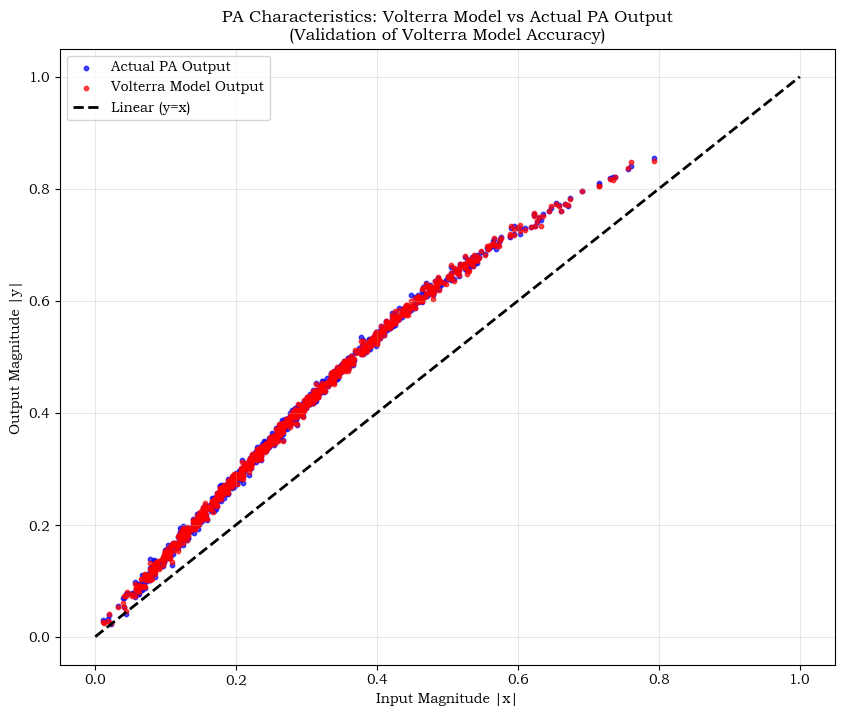

In [104]:
# Plot the Volterra Model vs the Actual PA Output y (how similar is volterra to actual output)
data_obj.plot_volterra_vs_actual(A, num_memory_levels_volterra, num_nl_orders)

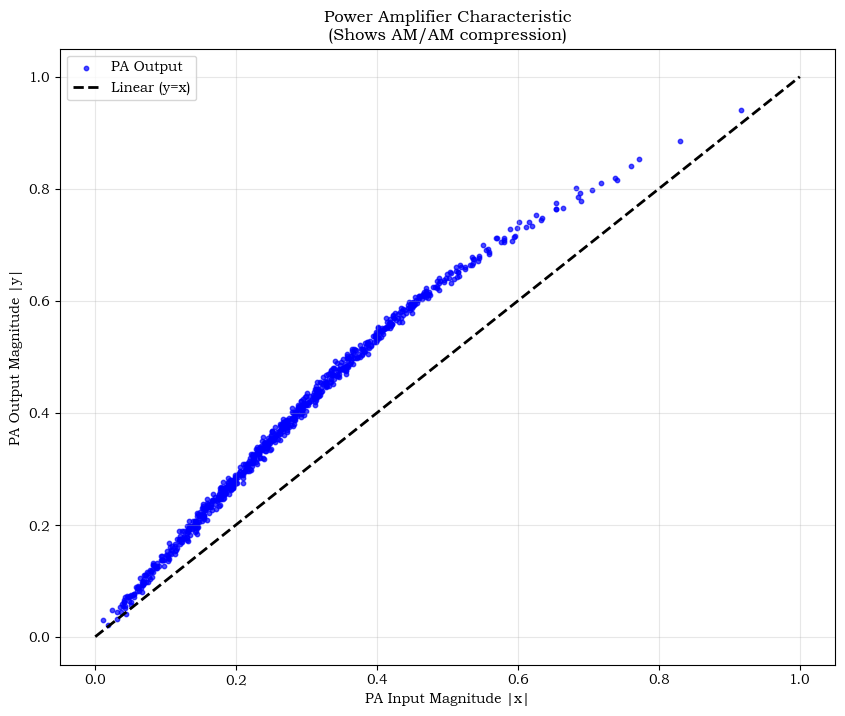

In [96]:
# Plot just the PA output characteristic (forward PA behavior)
data_obj.plot_pa_characteristic()


Computing NMSE for different memory depths...
Memory depth 1: NMSE = -31.33 dB
Memory depth 2: NMSE = -31.64 dB
Memory depth 3: NMSE = -37.57 dB
Memory depth 4: NMSE = -37.73 dB
Memory depth 5: NMSE = -37.79 dB
Memory depth 6: NMSE = -39.02 dB
Memory depth 7: NMSE = -40.05 dB
Memory depth 8: NMSE = -40.96 dB
Memory depth 9: NMSE = -41.11 dB
Memory depth 10: NMSE = -39.80 dB


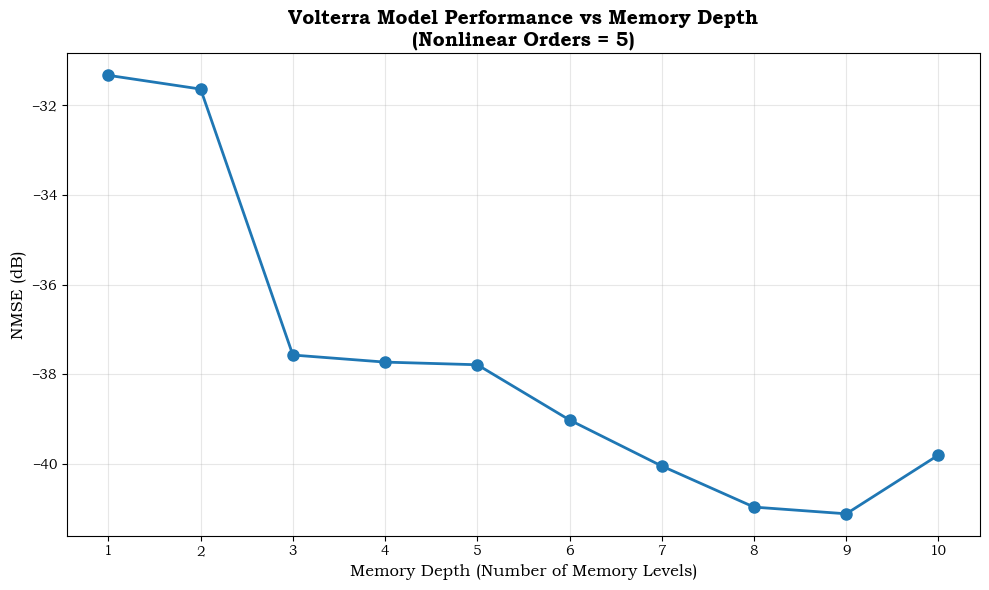

In [107]:
# Plot NMSE vs Memory Depth for Volterra Model
# This shows how model accuracy improves with more memory taps
memory_depths, nmse_values = data_obj.plot_volterra_nmse_vs_memory_depth(num_nl_orders=5, max_memory_levels=10)

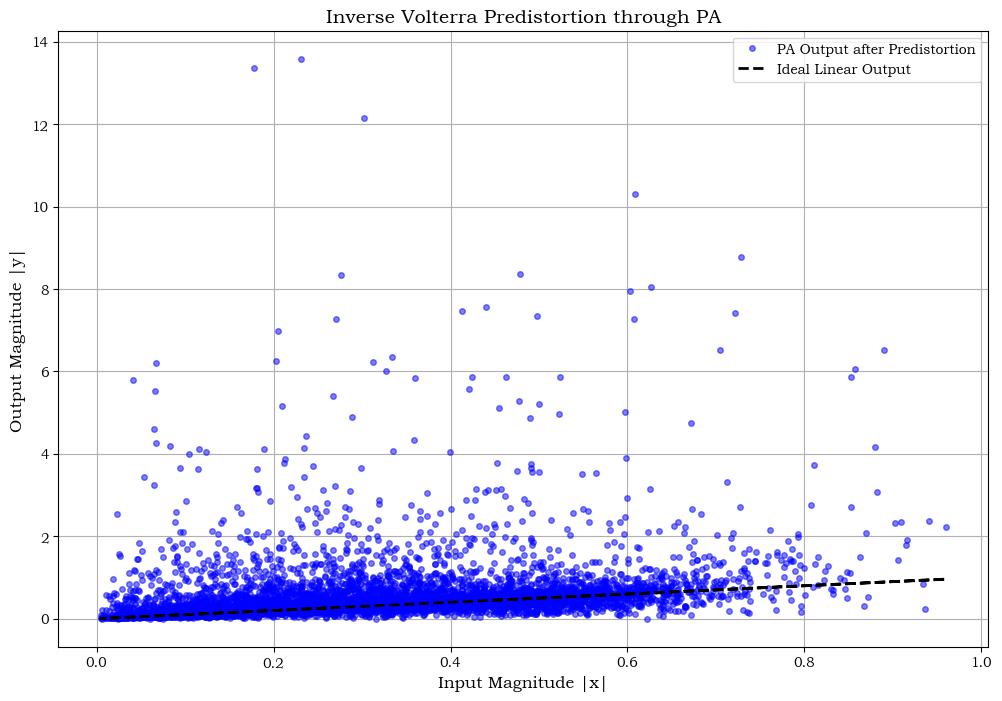

NMSE after Inverse Volterra Predistortion through PA: 6.06 dB


In [110]:
num_memory_levels_inverse = 3
num_nl_orders_inverse = 3


# Evaluate Inverse Volterra Predistortion through PA
# Learn inverse PA model (y -> x): distorted PA output -> clean input
# This is used for predistortion: given desired output x, predict what input u will give PA(u) ≈ x
A_inverse = data_obj.volterra(input=data_obj.model_training_input,   # y (distorted PA output)
                               output=data_obj.model_training_output, # x (clean input)
                               num_nl_orders=num_nl_orders_inverse, 
                               num_memory_levels=num_memory_levels_inverse)

# Test DPD: x (desired) -> A_inverse -> u (predistorted) -> A (forward PA) -> y (actual output)
x_aligned, volterra_predistorted, pa_output = data_obj.evaluate_inverse_volterra_through_pa(
    data_obj.test_input,  # x (clean desired output)
    A,  # Forward PA model (x -> y)
    A_inverse,  # Inverse model used for predistortion (x -> u such that PA(u) ≈ x)
    num_memory_levels_volterra, num_nl_orders,  # Forward PA model parameters
    num_memory_levels_inverse, num_nl_orders_inverse)  # Inverse model parameters

# Plot results of predistortion
plt.figure(figsize=(12, 8))
plt.plot(np.abs(x_aligned), np.abs(pa_output), 'b.', alpha=0.5, label='PA Output after Predistortion', markersize=8)
plt.plot(np.abs(x_aligned), np.abs(x_aligned), 'k--', label='Ideal Linear Output', linewidth=2)
plt.xlabel('Input Magnitude |x|', fontsize=12)
plt.ylabel('Output Magnitude |y|', fontsize=12)
plt.title('Inverse Volterra Predistortion through PA', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Calculate NMSE after predistortion
error_power = np.mean(np.abs(pa_output - x_aligned)**2)
signal_power = np.mean(np.abs(x_aligned)**2)
nmse_predistortion = error_power / signal_power
nmse_predistortion_db = 10 * np.log10(nmse_predistortion)
print(f'NMSE after Inverse Volterra Predistortion through PA: {nmse_predistortion_db:.2f} dB')

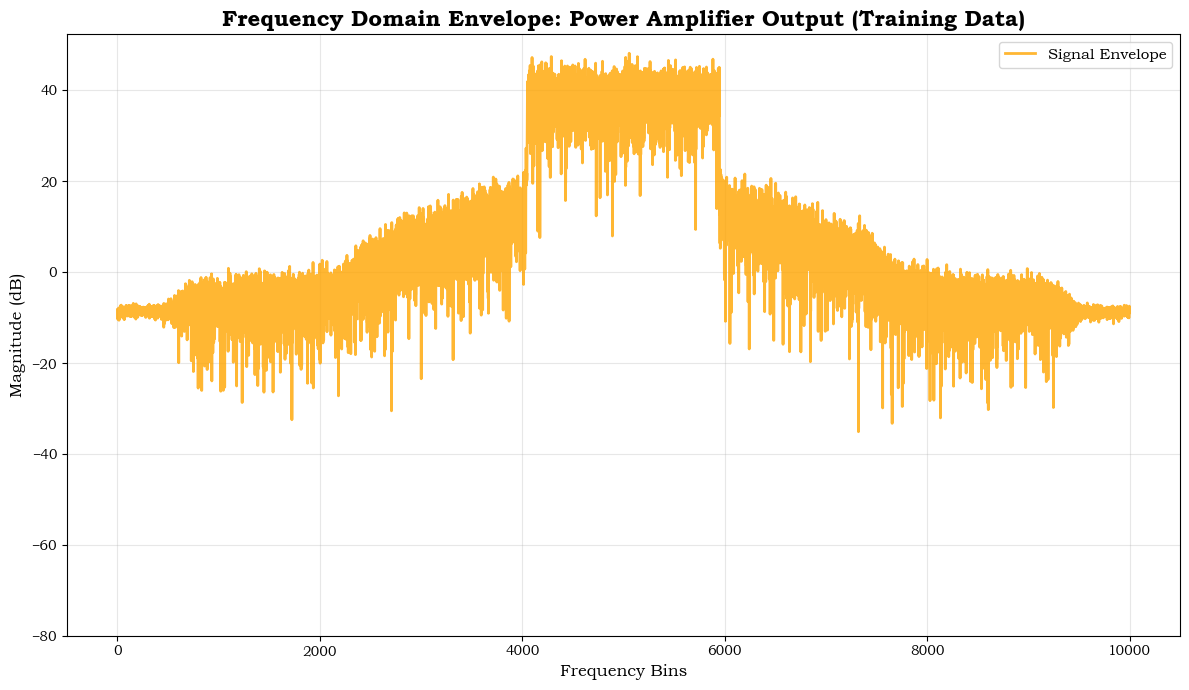

In [99]:
def plot_fft_data(y, y1=None, title_suffix=""):
    """Plot the FFT envelope of the output data, optionally with a second signal"""
    Y = np.fft.fft(y, n=len(y))
    Y_flip = np.fft.fftshift(Y)
    # Convert to dB and take envelope (magnitude)
    Y_dB = 20 * np.log10(np.abs(Y_flip))
    
    if y1 is not None:
        Y1 = np.fft.fft(y1, n=len(y1))
        Y1_flip = np.fft.fftshift(Y1)
        # Convert to dB and take envelope (magnitude)
        Y1_dB = 20 * np.log10(np.abs(Y1_flip))
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        ax1.plot(Y_dB, color='orange', linewidth=2, alpha=0.8)
        ax1.set_title('DPD Corrected Signal Envelope', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Frequency Bins', fontsize=12)
        ax1.set_ylabel('Magnitude (dB)', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(bottom=-80)
        
        ax2.plot(Y1_dB, color='blue', linewidth=2, alpha=0.8)
        ax2.set_title('Uncorrected PA Output Envelope', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Frequency Bins', fontsize=12)
        ax2.set_ylabel('Magnitude (dB)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(bottom=-80)
        
        plt.suptitle(f'Frequency Domain Envelope: {title_suffix}', fontsize=16, fontweight='bold')
        plt.tight_layout()
    else:
        plt.figure(figsize=(12, 7))
        plt.plot(Y_dB, color='orange', linewidth=2, alpha=0.8, label='Signal Envelope')
        plt.title(f'Frequency Domain Envelope: {title_suffix}', fontsize=16, fontweight='bold')
        plt.xlabel('Frequency Bins', fontsize=12)
        plt.ylabel('Magnitude (dB)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.ylim(bottom=-80)
        plt.legend(fontsize=11)
        plt.tight_layout()
    
    plt.show()

# Plot the PA output (distorted signal with intermodulation products)
plot_fft_data(data_obj.model_training_input, title_suffix="Power Amplifier Output (Training Data)")


In [100]:
# Train NN on backprop PA for inv model

class PNTDNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(PNTDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 2)

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
    


class PNTDNN_3_layers(nn.Module):    
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(PNTDNN_3_layers, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 2)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

class NN:
    def __init__(self, dataset_obj, model_type):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.input_size = dataset_obj.model_training_xfc.shape[1]
        self.pntdnn = self.get_model(model_type)
        self.dataset_obj = dataset_obj
        self.train_loader = self.build_dataloaders(dataset_obj.model_training_xfc, dataset_obj.model_training_expected_output)
        self.valid_loader = self.build_dataloaders(dataset_obj.model_valid_xfc, dataset_obj.model_valid_expected_output)

    def get_model(self, model_type):
        if model_type == "one_layer_12_neurons":
            hidden_size = 12
            return PNTDNN(self.input_size, hidden_size)
        else:
            raise ValueError("Unsupported model type")
        
    def build_dataloaders(self, x , y):
        X = torch.tensor(x, dtype=torch.float32)
        Y = torch.tensor(y, dtype=torch.float32)
        dataset = TensorDataset(X, Y)
        loader = DataLoader(dataset, batch_size=256, shuffle=True)
        return loader

    
    def get_best_model(self, num_epochs=400, learning_rate=1e-3):
        """Train model and return the best model based on validation loss"""
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.pntdnn.parameters(), lr=learning_rate)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
        
        train_losses = []
        valid_losses = []
        best_valid_loss = float('inf')
        best_model_state = None
        best_epoch = 0
        
        for epoch in range(num_epochs):
            self.pntdnn.train()
            running_train_loss = 0
            running_valid_loss = 0
            
            for xb, yb in self.train_loader:
                optimizer.zero_grad()
                preds = self.pntdnn(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item() * xb.size(0)
                
            train_loss = running_train_loss
            
            self.pntdnn.eval()
            with torch.no_grad():
                for xb, yb in self.valid_loader:
                    preds = self.pntdnn(xb)
                    loss = criterion(preds, yb)
                    running_valid_loss += loss.item() * xb.size(0)
                
            valid_loss = running_valid_loss
            
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            
            # Update learning rate based on validation loss
            scheduler.step(valid_loss)
            
            # Save best model
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_model_state = copy.deepcopy(self.pntdnn.state_dict())
                best_epoch = epoch + 1
            
            if (epoch + 1) % 10 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch + 1:3d}/{num_epochs}  Loss={train_loss:.4e}  Valid Loss={valid_loss:.4e}  LR={current_lr:.2e}")
        
        # Load best model
        self.pntdnn.load_state_dict(best_model_state)
        print(f"\nBest model from epoch {best_epoch} with validation loss: {best_valid_loss:.4e}")
        
        return train_losses, valid_losses, best_epoch

    def prune_model(self, parameters_to_prune_list, prune_amount=0.2):
        """Apply pruning to the model in-place"""
        parameters_to_prune = []

        if "fc1" in parameters_to_prune_list:
            parameters_to_prune.append((self.pntdnn.fc1, 'weight'))
        if "fc2" in parameters_to_prune_list:
            parameters_to_prune.append((self.pntdnn.fc2, 'weight'))
        if "fc3" in parameters_to_prune_list:
            parameters_to_prune.append((self.pntdnn.fc3, 'weight'))
        
        prune.global_unstructured(
            parameters_to_prune,
            pruning_method=prune.L1Unstructured,
            amount=prune_amount,
        )
    
    def get_pruning_percentage(self):
        """Calculate the current percentage of pruned weights"""
        total_params = 0
        pruned_params = 0
        for name, module in self.pntdnn.named_modules():
            if isinstance(module, nn.Linear):
                if hasattr(module, 'weight_mask'):
                    mask = module.weight_mask
                    total_params += mask.numel()
                    pruned_params += (mask == 0).sum().item()
                else:
                    total_params += module.weight.numel()
        
        return (pruned_params / total_params * 100) if total_params > 0 else 0
    
    def calculate_nmse(self):
        """Return NMSE in dB"""
        self.pntdnn.eval()
        x = self.dataset_obj.model_training_xfc
        y = self.dataset_obj.model_training_expected_output
        with torch.no_grad():
            inputs = torch.tensor(x, dtype=torch.float32)
            targets = torch.tensor(y, dtype=torch.float32)
            outputs = self.pntdnn(inputs)
            mse_loss = nn.MSELoss()(outputs, targets).item()
            signal_power = torch.mean(targets ** 2).item()
            nmse = mse_loss / signal_power
            nmse = 10 * np.log10(nmse)
        return nmse
    
    def evaluate_nn_output(self, x):
        """Evaluate model output for given input x."""
        self.pntdnn.eval()
        with torch.no_grad():
            inputs = torch.tensor(x, dtype=torch.float32)
            outputs = self.pntdnn(inputs)
        return outputs.numpy()
    
    def evaluate_phase_denormalised_output(self, x, phase):
        """Evaluate model output for given input x with phase denormalization."""
        nn_outputs = self.evaluate_nn_output(x)
        output = (nn_outputs[:, 0] + 1j * nn_outputs[:, 1]) * np.conj(phase)
        return output
    
    def evaluate_output_through_pa(self, data_obj, x, num_memory_levels_volterra=3, num_nl_orders=5):
        """
        Evaluate DPD system: x → NN (predistortion) → PA → output
        
        Args:
            data_obj: Dataset object (uses data_obj.num_memory_levels_nn for NN features)
            x: Input signal
            num_memory_levels_volterra: Memory levels for Volterra PA model
            num_nl_orders: Nonlinear orders for Volterra PA model
        
        Returns aligned arrays accounting for double trimming (build_xfc + build_y):
            x_aligned: Input signal trimmed by (num_memory_levels_nn + num_memory_levels_volterra)
            nn_output: NN predistorted output (trimmed by num_memory_levels_nn + num_memory_levels_volterra)
            pa_output: Final PA output (trimmed by num_memory_levels_nn + num_memory_levels_volterra)
        """
        # Build features from input signal using NN memory levels
        num_memory_levels_nn = data_obj.num_memory_levels_nn
        test_xfc = data_obj.build_xfc(x, num_memory_levels_nn)

        # Get phase and trim it to match xfc length
        phase_full = data_obj.phase_vector(x)
        phase = phase_full[num_memory_levels_nn:]

        # Get NN output (predistorted signal u)
        nn_outputs = self.evaluate_nn_output(test_xfc)
        
        # Convert NN output back to complex form and denormalize
        nn_outputs_complex = (nn_outputs[:, 0] + 1j * nn_outputs[:, 1]) * np.conj(phase)

        # Use FORWARD PA model (clean x → distorted y) to simulate real PA
        # Training data: x = clean input, y = PA output
        A = data_obj.volterra(input=data_obj.model_training_output,  # x (clean)
                               output=data_obj.model_training_input,   # y (distorted)
                               num_nl_orders=num_nl_orders, num_memory_levels=num_memory_levels_volterra)
        
        # Pass through PA Volterra model (this trims another num_memory_levels_volterra samples)
        pa_output = data_obj.build_y(nn_outputs_complex, A, num_memory_levels_volterra, num_nl_orders).squeeze()
        
        # Align all arrays properly:
        # - x needs double trimming (num_memory_levels_nn + num_memory_levels_volterra) because of build_xfc + build_y
        # - nn_outputs_complex was trimmed once (num_memory_levels_nn from build_xfc), needs volterra trim
        # - pa_output is already double-trimmed implicitly
        total_trim = num_memory_levels_nn + num_memory_levels_volterra
        x_aligned = x[total_trim:]
        nn_output = nn_outputs_complex[num_memory_levels_volterra:]  # Align with x_aligned
        
        # Ensure all arrays are same length
        min_len = min(len(pa_output), len(x_aligned), len(nn_output))
        x_aligned = x_aligned[:min_len]
        pa_output = pa_output[:min_len]
        nn_output = nn_output[:min_len]
        
        return x_aligned, nn_output, pa_output




In [101]:
# Instantiate and train the model

nn_model = NN(data_obj, model_type="one_layer_12_neurons")

train_losses, valid_losses, best_epoch = nn_model.get_best_model(num_epochs=500)
print(nn_model.calculate_nmse())

Epoch  10/500  Loss=3.4372e+00  Valid Loss=3.1333e+00  LR=1.00e-03
Epoch  20/500  Loss=7.4645e-01  Valid Loss=7.0960e-01  LR=1.00e-03
Epoch  30/500  Loss=3.5239e-01  Valid Loss=3.5583e-01  LR=1.00e-03
Epoch  40/500  Loss=2.7921e-01  Valid Loss=3.0998e-01  LR=1.00e-03
Epoch  50/500  Loss=2.4533e-01  Valid Loss=2.4743e-01  LR=1.00e-03
Epoch  60/500  Loss=2.3617e-01  Valid Loss=2.5153e-01  LR=1.00e-03
Epoch  70/500  Loss=2.1922e-01  Valid Loss=2.1873e-01  LR=1.00e-03
Epoch  80/500  Loss=2.0754e-01  Valid Loss=2.4969e-01  LR=1.00e-03
Epoch  90/500  Loss=2.0507e-01  Valid Loss=1.9985e-01  LR=1.00e-03
Epoch 100/500  Loss=1.9681e-01  Valid Loss=1.9876e-01  LR=1.00e-03
Epoch 110/500  Loss=1.8490e-01  Valid Loss=1.8352e-01  LR=1.00e-03


KeyboardInterrupt: 

In [ ]:
# Evaluate DPD performance
x_test, y_test = data_obj.get_leftover_test_data()

# Use same test subset as diagnostic cell for fair comparison
x_test_subset = x_test[:5000]
y_test_subset = y_test[:5000]

# Get aligned x, NN output, and PA output (handles all trimming automatically)
x_aligned, nn_output, pa_output = nn_model.evaluate_output_through_pa(data_obj, x_test_subset, num_memory_levels_volterra)

# Calculate how much was actually trimmed from the front
actual_trim = len(x_test_subset) - len(x_aligned)

# Trim y_test by the same amount to ensure perfect alignment
y_test_aligned = y_test_subset[actual_trim:][:len(x_aligned)]

# For the NN output plot, use x_aligned (already properly aligned with nn_output)
x_for_nn_plot = x_aligned

# Create 3 scatter plots showing PA characteristics
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: NN output (u) vs clean input (x) - Inverse PA characteristic
ax1.scatter(np.abs(x_for_nn_plot), np.abs(nn_output), color='red', alpha=0.5, s=10)
ax1.plot([0, 1.2], [0, 1.2], 'k--', label='y=x (linear)', linewidth=2)
ax1.set_xlabel('|x_test| (Clean Input)')
ax1.set_ylabel('|NN output u| (Predistorted)')
ax1.set_title('Inverse PA: NN predistorts signal')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: PA(NN(x)) vs x - DPD linearization performance
ax2.scatter(np.abs(x_aligned), np.abs(pa_output), color='green', alpha=0.5, s=10)
ax2.plot([0, 1.2], [0, 1.2], 'k--', label='y=x (perfect linearization)', linewidth=2)
ax2.set_xlabel('|x_test| (Clean Input)')
ax2.set_ylabel('|PA(NN output)| (Final Output)')
ax2.set_title('DPD Performance: Should follow diagonal')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: PA(x) vs x - Forward PA characteristic
ax3.scatter(np.abs(x_aligned), np.abs(y_test_aligned), color='blue', alpha=0.5, s=10)
ax3.plot([0, 1.2], [0, 1.2], 'k--', label='y=x (linear)', linewidth=2)
ax3.set_xlabel('|x_test| (Clean Input)')
ax3.set_ylabel('|y_test| (PA Output without DPD)')
ax3.set_title('Forward PA: Shows compression/distortion')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate NMSE improvement
nmse_no_dpd = 10 * np.log10(np.mean(np.abs(y_test_aligned - x_aligned)**2) / np.mean(np.abs(x_aligned)**2))
nmse_with_dpd = 10 * np.log10(np.mean(np.abs(pa_output - x_aligned)**2) / np.mean(np.abs(x_aligned)**2))
improvement = nmse_no_dpd - nmse_with_dpd

print(f"NMSE without DPD: {nmse_no_dpd:.2f} dB")
print(f"NMSE with DPD: {nmse_with_dpd:.2f} dB")
print(f"Improvement: {improvement:.2f} dB")

# FFT comparison
plot_fft_data(pa_output, y1=y_test_aligned, title_suffix="FFT: DPD Output (orange) vs No DPD (blue)")

In [ ]:
class Experiment:
    def __init__(self, nn_model, num_prune_iterations, prune_amount, retrain_epochs, dataset_obj):
        self.original_nn_model = nn_model  # Keep original model untouched
        self.nn_model = None  # Will be set to working copy
        self.num_prune_iterations = num_prune_iterations
        self.prune_amount = prune_amount
        self.retrain_epochs = retrain_epochs
        self.model_xfc = dataset_obj.model_training_xfc
        self.model_training_expected_output = dataset_obj.model_training_expected_output
        self.valid_xfc = dataset_obj.model_valid_input
        self.model_valid_expected_output = dataset_obj.model_valid_expected_output
    
    def run(self):
        nmse_results = []
        prune_percentages = []
        valid_losses_final = []
        all_valid_losses = []
        all_best_epochs = []
        
        # Create a working copy from the original model
        working_pntdnn = copy.deepcopy(self.original_nn_model.pntdnn)
        self.nn_model = NN(self.original_nn_model.dataset_obj, model_type="one_layer_12_neurons")

        for i in range(self.num_prune_iterations):
            print(f"\n{'='*60}")
            print(f"Pruning Iteration {i+1}/{self.num_prune_iterations}")
            print(f"{'='*60}")
            
            # Apply pruning to the current model (iterative pruning of remaining weights)
            print(f"Pruning {self.prune_amount*100:.1f}% of remaining weights...")
            self.nn_model.prune_model(["fc1", "fc2"], self.prune_amount)
            
            # Calculate current pruning percentage
            current_prune_pct = self.nn_model.get_pruning_percentage()
            prune_percentages.append(current_prune_pct)
            print(f"Current pruning: {current_prune_pct:.2f}% of weights are zero")
            
            # Retrain the model
            print(f"Retraining for {self.retrain_epochs} epochs...")
            train_losses, valid_losses, best_epoch = self.nn_model.get_best_model(
                num_epochs=self.retrain_epochs
            )
            
            # Store validation losses and best epoch
            all_valid_losses.append(valid_losses)
            all_best_epochs.append(best_epoch)
            valid_losses_final.append(min(valid_losses))
            
            # Calculate NMSE
            nmse = self.nn_model.calculate_nmse()
            nmse_results.append(nmse)
            print(f"NMSE: {nmse:.4f} dB")

        self.plot_results(prune_percentages, nmse_results, valid_losses_final)
        # self.plot_training_curves(all_valid_losses, all_best_epochs, prune_percentages)
        
        return prune_percentages, nmse_results, valid_losses_final

    def plot_results(self, prune_percentages, nmse_results, valid_losses):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Plot NMSE
        ax1.plot(prune_percentages, nmse_results, marker='o', linewidth=2, markersize=8, color='tab:blue')
        ax1.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax1.set_ylabel('NMSE (dB)', fontsize=12)
        ax1.set_title('Model Performance vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Plot Validation Loss
        ax2.plot(prune_percentages, valid_losses, marker='s', linewidth=2, markersize=8, color='tab:orange')
        ax2.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax2.set_ylabel('Best Validation Loss', fontsize=12)
        ax2.set_title('Validation Loss vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_training_curves(self, all_valid_losses, all_best_epochs, prune_percentages):
        """Plot validation loss curves for each pruning iteration with best epoch markers"""
        n_iterations = len(all_valid_losses)
        colors = plt.cm.viridis(np.linspace(0, 1, n_iterations))
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for i, (valid_losses, best_epoch, prune_pct, color) in enumerate(zip(all_valid_losses, all_best_epochs, prune_percentages, colors)):
            epochs = range(1, len(valid_losses) + 1)
            label = f'Iter {i+1}: {prune_pct:.1f}% pruned'
            
            # Plot validation loss curve
            ax.plot(epochs, valid_losses, linewidth=2, color=color, label=label, alpha=0.7)
            
            # Add vertical line at best epoch
            ax.axvline(x=best_epoch, color=color, linestyle='--', linewidth=1.5, alpha=0.8)
            
            # Add marker at best epoch
            best_loss = valid_losses[best_epoch - 1]
            ax.plot(best_epoch, best_loss, marker='*', markersize=12, color=color, 
                   markeredgecolor='black', markeredgewidth=1)
        
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Validation Loss', fontsize=12)
        ax.set_title('Validation Loss Curves for Each Pruning Iteration', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    

In [ ]:
class Non_Linear_Prune_Experiment:
    def __init__(self, nn_model, prune_schedule, retrain_epochs, model_xfc, model_training_expected_output, valid_xfc, model_valid_expected_output):
        """
        Args:
            nn_model: The trained neural network model
            prune_schedule: List of pruning amounts for each iteration (e.g., [0.5, 0.2, 0.1, 0.05, 0.05])
            retrain_epochs: Number of epochs to retrain after each pruning
            model_xfc: Training features
            model_training_expected_output: Training targets
            valid_xfc: Validation features
            model_valid_expected_output: Validation targets
        """
        self.original_nn_model = nn_model  # Keep original model untouched
        self.nn_model = None  # Will be set to working copy
        self.prune_schedule = prune_schedule
        self.num_prune_iterations = len(prune_schedule)
        self.retrain_epochs = retrain_epochs
        self.model_xfc = model_xfc
        self.model_training_expected_output = model_training_expected_output
        self.valid_xfc = valid_xfc
        self.model_valid_expected_output = model_valid_expected_output
    
    def run(self):
        nmse_results = []
        prune_percentages = []
        valid_losses_final = []
        all_valid_losses = []
        all_best_epochs = []
        
        # Create a working copy from the original model
        working_pntdnn = copy.deepcopy(self.original_nn_model.pntdnn)
        self.nn_model = NN(working_pntdnn, self.model_xfc, self.model_training_expected_output, self.valid_xfc)

        for i in range(self.num_prune_iterations):
            print(f"\n{'='*60}")
            print(f"Pruning Iteration {i+1}/{self.num_prune_iterations}")
            print(f"{'='*60}")
            
            # Apply pruning to the current model (iterative pruning of remaining weights)
            print(f"Pruning {self.prune_schedule[i]*100:.1f}% of remaining weights...")
            self.nn_model.prune_model(["fc1", "fc2"], self.prune_schedule[i])
            
            # Calculate current pruning percentage
            current_prune_pct = self.nn_model.get_pruning_percentage()
            prune_percentages.append(current_prune_pct)
            print(f"Current pruning: {current_prune_pct:.2f}% of weights are zero")
            
            # Retrain the model
            print(f"Retraining for {self.retrain_epochs} epochs...")
            train_losses, valid_losses, best_epoch = self.nn_model.get_best_model(
                num_epochs=self.retrain_epochs
            )
            
            # Store validation losses and best epoch
            all_valid_losses.append(valid_losses)
            all_best_epochs.append(best_epoch)
            valid_losses_final.append(min(valid_losses))
            
            # Calculate NMSE
            nmse = self.nn_model.calculate_nmse()
            nmse_results.append(nmse)
            print(f"NMSE: {nmse:.4f} dB")

        self.plot_results(prune_percentages, nmse_results, valid_losses_final)
        
        return prune_percentages, nmse_results, valid_losses_final

    def plot_results(self, prune_percentages, nmse_results, valid_losses):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Plot NMSE
        ax1.plot(prune_percentages, nmse_results, marker='o', linewidth=2, markersize=8, color='tab:blue')
        ax1.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax1.set_ylabel('NMSE (dB)', fontsize=12)
        ax1.set_title('Model Performance vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Plot Validation Loss
        ax2.plot(prune_percentages, valid_losses, marker='s', linewidth=2, markersize=8, color='tab:orange')
        ax2.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax2.set_ylabel('Best Validation Loss', fontsize=12)
        ax2.set_title('Validation Loss vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_training_curves(self, all_valid_losses, all_best_epochs, prune_percentages):
        """Plot validation loss curves for each pruning iteration with best epoch markers"""
        n_iterations = len(all_valid_losses)
        colors = plt.cm.viridis(np.linspace(0, 1, n_iterations))
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for i, (valid_losses, best_epoch, prune_pct, color) in enumerate(zip(all_valid_losses, all_best_epochs, prune_percentages, colors)):
            epochs = range(1, len(valid_losses) + 1)
            label = f'Iter {i+1}: {prune_pct:.1f}% pruned'
            
            # Plot validation loss curve
            ax.plot(epochs, valid_losses, linewidth=2, color=color, label=label, alpha=0.7)
            
            # Add vertical line at best epoch
            ax.axvline(x=best_epoch, color=color, linestyle='--', linewidth=1.5, alpha=0.8)
            
            # Add marker at best epoch
            best_loss = valid_losses[best_epoch - 1]
            ax.plot(best_epoch, best_loss, marker='*', markersize=12, color=color, 
                   markeredgecolor='black', markeredgewidth=1)
        
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Validation Loss', fontsize=12)
        ax.set_title('Validation Loss Curves for Each Pruning Iteration', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def compare_pruning_strategies(linear_results, nonlinear_results):
        """
        Compare linear and non-linear pruning strategies side by side
        
        Args:
            linear_results: tuple of (prune_percentages, nmse_results, valid_losses)
            nonlinear_results: tuple of (prune_percentages, nmse_results, valid_losses)
        """
        linear_prune_pct, linear_nmse, linear_valid = linear_results
        nonlinear_prune_pct, nonlinear_nmse, nonlinear_valid = nonlinear_results
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot NMSE comparison
        ax1.plot(linear_prune_pct, linear_nmse, marker='o', linewidth=2, markersize=8, 
                color='tab:blue', label='Linear Pruning')
        ax1.plot(nonlinear_prune_pct, nonlinear_nmse, marker='s', linewidth=2, markersize=8, 
                color='tab:red', label='Non-Linear Pruning')
        ax1.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax1.set_ylabel('NMSE (dB)', fontsize=12)
        ax1.set_title('Model Performance: Linear vs Non-Linear Pruning', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Plot Validation Loss comparison
        ax2.plot(linear_prune_pct, linear_valid, marker='o', linewidth=2, markersize=8, 
                color='tab:blue', label='Linear Pruning')
        ax2.plot(nonlinear_prune_pct, nonlinear_valid, marker='s', linewidth=2, markersize=8, 
                color='tab:red', label='Non-Linear Pruning')
        ax2.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax2.set_ylabel('Best Validation Loss', fontsize=12)
        ax2.set_title('Validation Loss: Linear vs Non-Linear Pruning', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    



In [ ]:
# Run linear pruning experiment
print("="*70)
print("RUNNING LINEAR PRUNING EXPERIMENT")
print("="*70)
linear_experiment = Experiment(nn_model, num_prune_iterations=20, prune_amount=0.1, retrain_epochs=200,
                               dataset_obj=data_obj)
linear_prune_pct, linear_nmse, linear_valid = linear_experiment.run()

In [ ]:
# Run non-linear pruning experiment
print("\n" + "="*70)
print("RUNNING NON-LINEAR PRUNING EXPERIMENT")
print("="*70)
nonlinear_prune_schedule = [0.5, 0.5, 0.1, 0.1]  # Custom pruning schedule
nonlinear_experiment = Non_Linear_Prune_Experiment(nn_model, prune_schedule=nonlinear_prune_schedule, 
                                                    retrain_epochs=500,
                                                    model_xfc=model_xfc, 
                                                    model_training_expected_output=model_training_expected_output,
                                                    valid_xfc=valid_xfc, 
                                                    model_valid_expected_output=model_valid_expected_output)
nonlinear_prune_pct, nonlinear_nmse, nonlinear_valid = nonlinear_experiment.run()

# Compare both strategies
print("\n" + "="*70)
print("COMPARING PRUNING STRATEGIES")
print("="*70)
Non_Linear_Prune_Experiment.compare_pruning_strategies(
    (linear_prune_pct, linear_nmse, linear_valid),
    (nonlinear_prune_pct, nonlinear_nmse, nonlinear_valid)
)

In [ ]:
# Experiment on just pruning F1

class Prune_fc1_only_Experiment:
    def __init__(self, nn_model, num_prune_iterations, prune_amount, retrain_epochs, model_xfc, model_training_expected_output, valid_xfc, model_valid_expected_output):
        self.original_nn_model = nn_model  # Keep original model untouched
        self.nn_model = None  # Will be set to working copy
        self.num_prune_iterations = num_prune_iterations
        self.prune_amount = prune_amount
        self.retrain_epochs = retrain_epochs
        self.model_xfc = model_xfc
        self.model_training_expected_output = model_training_expected_output
        self.valid_xfc = valid_xfc
        self.model_valid_expected_output = model_valid_expected_output
    
    def run(self):
        nmse_results = []
        prune_percentages = []
        valid_losses_final = []
        all_valid_losses = []
        all_best_epochs = []
        
        # Create a working copy from the original model
        working_pntdnn = copy.deepcopy(self.original_nn_model.pntdnn)
        self.nn_model = NN(working_pntdnn)

        for i in range(self.num_prune_iterations):
            print(f"\n{'='*60}")
            print(f"Pruning Iteration {i+1}/{self.num_prune_iterations}")
            print(f"{'='*60}")
            
            # Apply pruning to the current model (iterative pruning of remaining weights)
            print(f"Pruning {self.prune_amount*100:.1f}% of remaining fc1 weights...")
            self.nn_model.prune_model(["fc1"], self.prune_amount)
            
            # Calculate current pruning percentage
            current_prune_pct = self.nn_model.get_pruning_percentage()
            prune_percentages.append(current_prune_pct)
            print(f"Current pruning: {current_prune_pct:.2f}% of weights are zero")
            
            # Retrain the model
            print(f"Retraining for {self.retrain_epochs} epochs...")
            train_loader = self.nn_model.build_dataloaders(self.model_xfc, self.model_training_expected_output)
            valid_loader = self.nn_model.build_dataloaders(self.valid_xfc, self.model_valid_expected_output)
            train_losses, valid_losses, best_epoch = self.nn_model.get_best_model(
                train_loader, valid_loader, num_epochs=self.retrain_epochs
            )
            
            # Store validation losses and best epoch
            all_valid_losses.append(valid_losses)
            all_best_epochs.append(best_epoch)
            valid_losses_final.append(min(valid_losses))
            
            # Calculate NMSE
            nmse = self.nn_model.calculate_nmse()
            nmse_results.append(nmse)
            print(f"NMSE: {nmse:.4f} dB")

        self.plot_results(prune_percentages, nmse_results, valid_losses_final)
        # self.plot_training_curves(all_valid_losses, all_best_epochs, prune_percentages)
        
        return prune_percentages, nmse_results, valid_losses_final

    def plot_results(self, prune_percentages, nmse_results, valid_losses):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
        
        # Plot NMSE
        ax1.plot(prune_percentages, nmse_results, marker='o', linewidth=2, markersize=8, color='tab:blue')
        ax1.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax1.set_ylabel('NMSE (dB)', fontsize=12)
        ax1.set_title('Model Performance vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Plot Validation Loss
        ax2.plot(prune_percentages, valid_losses, marker='s', linewidth=2, markersize=8, color='tab:orange')
        ax2.set_xlabel('Pruning Percentage (%)', fontsize=12)
        ax2.set_ylabel('Best Validation Loss', fontsize=12)
        ax2.set_title('Validation Loss vs Pruning Percentage', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_training_curves(self, all_valid_losses, all_best_epochs, prune_percentages):
        """Plot validation loss curves for each pruning iteration with best epoch markers"""
        n_iterations = len(all_valid_losses)
        colors = plt.cm.viridis(np.linspace(0, 1, n_iterations))
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for i, (valid_losses, best_epoch, prune_pct, color) in enumerate(zip(all_valid_losses, all_best_epochs, prune_percentages, colors)):
            epochs = range(1, len(valid_losses) + 1)
            label = f'Iter {i+1}: {prune_pct:.1f}% pruned'
            
            # Plot validation loss curve
            ax.plot(epochs, valid_losses, linewidth=2, color=color, label=label, alpha=0.7)
            
            # Add vertical line at best epoch
            ax.axvline(x=best_epoch, color=color, linestyle='--', linewidth=1.5, alpha=0.8)
            
            # Add marker at best epoch
            best_loss = valid_losses[best_epoch - 1]
            ax.plot(best_epoch, best_loss, marker='*', markersize=12, color=color, 
                   markeredgecolor='black', markeredgewidth=1)
        
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Validation Loss', fontsize=12)
        ax.set_title('Validation Loss Curves for Each Pruning Iteration', fontsize=14, fontweight='bold')
        ax.legend(loc='best', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    

In [ ]:
# Run fc1 only pruning experiment
print("="*70)
print("RUNNING FC1 ONLY PRUNING EXPERIMENT")
print("="*70)
fc1_only_experiment = Prune_fc1_only_Experiment(nn_model, num_prune_iterations=20, prune_amount=0.1, retrain_epochs=200,
                               model_xfc=model_xfc, model_training_expected_output=model_training_expected_output,
                               valid_xfc=valid_xfc, model_valid_expected_output=model_valid_expected_output)
fc1_prune_pct, fc1_nmse, fc1_valid = fc1_only_experiment.run()

In [ ]:
# Train 3 layer NN
# Instantiate and train the model
input_size = model_xfc.shape[1]
hidden_size_1 = 12
hidden_size_2e = 2
PNTDNN_3_layers_model = PNTDNN_3_layers(input_size, hidden_size_1, hidden_sze_2, utput


_
size)


In [ ]:
# Train a 1 layer model with a bigger hidden layer
input_size = model_xfc.shape[1]
hidden_size = 20
output_size = 2
pntdnn = PNTDNN(input_size, hidden_size)
nn_model = NN(pntdnn)
train_loader = nn_model.build_dataloaders(model_xfc, model_training_expected_output)
valid_loader = nn_model.build_dataloaders(valid_xfc, model_valid_expected_output)
train_losses, valid_losses, best_epoch = nn_model.get_best_model(train_loader, valid_loader, num_epochs=2000)
print(nn_model.calculate_nmse(model_xfc, model_training_expected_output))


In [ ]:
# Train a model with 1 smaller hidden layer
input_size = model_xfc.shape[1]
hidden_size = 7
output_size = 2
pntdnn = PNTDNN(input_size, hidden_size, output_size)
nn_model = NN(pntdnn)
train_loader = nn_model.build_dataloaders(model_xfc, model_training_expected_output)
valid_loader = nn_model.build_dataloaders(valid_xfc, model_valid_expected_output)
train_losses, valid_losses, best_epoch = nn_model.get_best_model(train_loader, valid_loader, num_epochs=2000)
print(nn_model.calculate_nmse(model_xfc, model_training_expected_output))

